# MoO3 + Fe2O3 (bulk) tomography dataset

Collected at BNL, FXI 18-ID, June 2022  

Paul Chao, pchao [at] umich.edu  
July 7, 2022

Post reaction tomography

v2: use extracted flats and darks from 5939

In [16]:
import tomopy
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tifffile
import os
import time
from PIL import Image

In [17]:
file_path = 'fly_scan_id_6094.h5';
#file_path = os.path.join('D:', os.sep, 'Data_storage', os.sep, '2021_data', os.sep, 'BNL Dec 2021', os.sep, 'fly_scan_id_118334.h5')
#file = h5py.File(file_path, 'r')

In [21]:
with h5py.File(file_path, 'r') as file:
    print(list(file.keys()))
    print(file["img_tomo"].shape)
    
    print('X-ray energy: ' + str(np.array(file.get("X_eng"))) + 'keV')
    print('Pixel Size: ' + str(np.array(file.get("Pixel Size"))))
    print('note: ' +str(np.array(file.get("note"))))

['Magnification', 'Pixel Size', 'X_eng', 'acquisition_period', 'ang_range', 'angle', 'binning', 'exposure_time', 'filters', 'img_bkg', 'img_bkg_avg', 'img_dark', 'img_dark_avg', 'img_tomo', 'note', 'r_ini', 'scan_id', 'scan_time', 'slew_velocity', 'start_angle', 'uid', 'x_ini', 'y_ini', 'z_ini']
(1108, 2160, 2560)
X-ray energy: 8.5keV
Pixel Size: b'21.276513520349514nm'
note: b'MoO3-Fe2O3_postrxn_GEK'


## Use separate Flat Fields collected during session (8.5keV)

In [22]:
dark_avg_im = Image.open('5939_dark_avg.tif')
dark_avg = np.array(dark_avg_im)
dark_avg = np.expand_dims(dark_avg,axis=0)
print(dark_avg.shape)

ff_avg_im = Image.open('5939_ff_avg.tif')
ff_avg = np.array(ff_avg_im)
ff_avg = np.expand_dims(ff_avg,axis=0)
print(ff_avg.shape)

(1, 2160, 2560)
(1, 2160, 2560)


### Look at raw data (can also use HDFView)

Tomography data consists of forward projection images over an angular range of usually 180 degrees


Text(0, 0.5, 'Stage Y')

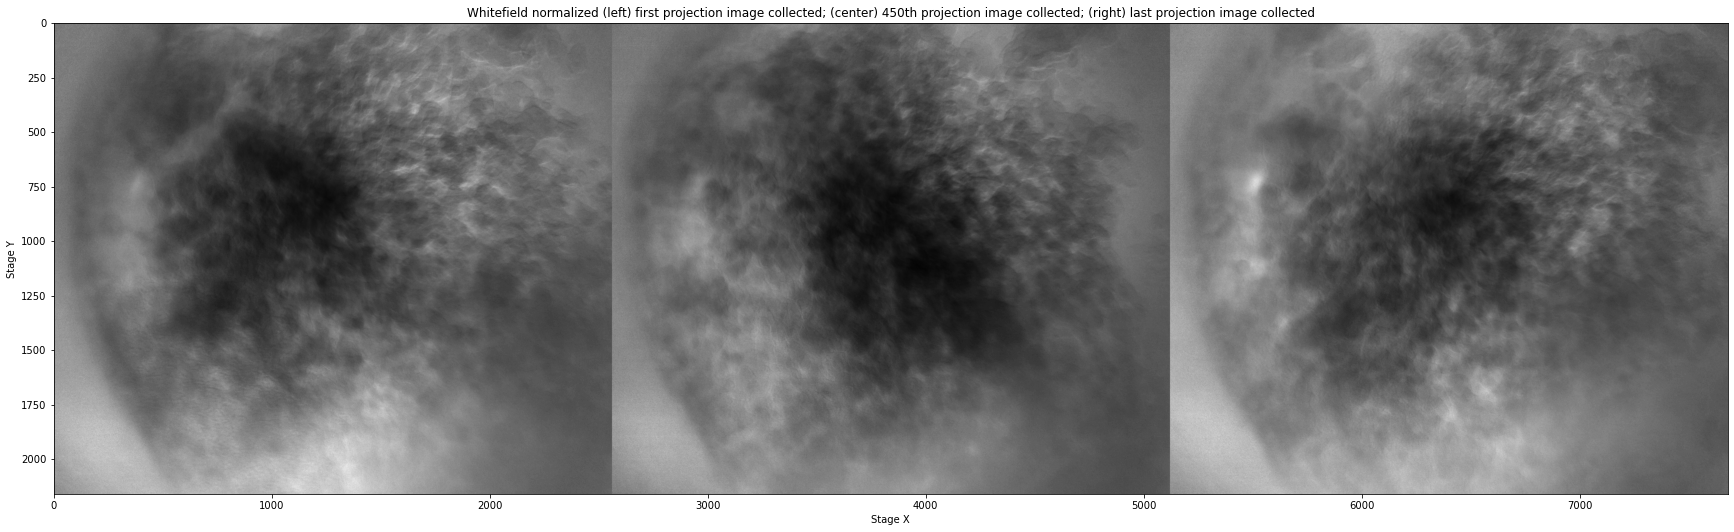

In [24]:
with h5py.File(file_path, 'r') as file:
    first_prj = file["img_tomo"][1,:,:]
    mid_prj = file["img_tomo"][450,:,:]
    last_prj = file["img_tomo"][-1,:,:]

white_prj = ff_avg
dark_prj = dark_avg

# Montage
prj_images = np.concatenate((np.divide(first_prj,white_prj),np.divide(mid_prj,white_prj),np.divide(last_prj,white_prj)), axis=2)
plt.figure(figsize = (30,15))
plt.title('Whitefield normalized (left) first projection image collected; (center) 450th projection image collected; (right) last projection image collected')
plt.imshow(np.squeeze(prj_images), cmap = 'gray') #squeeze(), removes axis of size 1
plt.xlabel("Stage X")
plt.ylabel("Stage Y")

### Import data and process
1. Normalize with white and dark field
2. Remove stripes (in sinogram space) because of detector dead pixels
3. Take negative log because of Beer-Lambert law to back out the phase attenuation

In [26]:
chunk_size = 5
#num_chunks = 1 #512, 1024, 1536
chunk_start = 1500
chunk_end = chunk_start+chunk_size

time_start = time.time()

with h5py.File(file_path, 'r') as file:
    tomodata = file["img_tomo"][:,chunk_start:chunk_end,:]
    #theta = np.linspace(0,2*np.pi,tomodata.shape[0])

white =  white_prj[:,chunk_start:chunk_end,:]
dark =  dark_prj[:,chunk_start:chunk_end,:]

#print(' *** Normalizing')
proj = tomopy.normalize(tomodata, white, dark)

#print(' *** Remove Stripes')
proj = tomopy.prep.stripe.remove_all_stripe(proj)

# remove negative numbers
proj = tomopy.misc.corr.remove_neg(proj, val=1e-3)

#print(' *** - log')
proj = tomopy.minus_log(proj)

time_end  = time.time()
print(' *** prep done in ' + str(round((time_end-time_start)/60,2)) + ' minutes')

 *** prep done in 0.18 minutes


### Show the sinogram
The sinogram is the projections under different angles organized in 2D

(1108, 5, 2560)


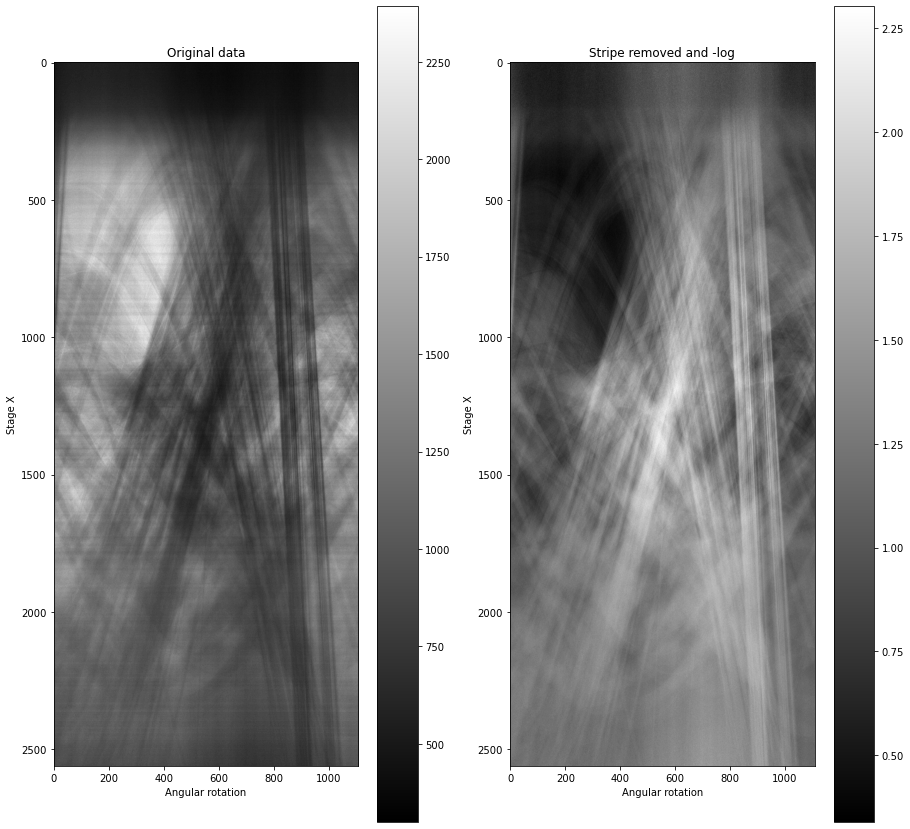

In [27]:
print(tomodata.shape)
fig, axs = plt.subplots(1,2,figsize=(15, 15))
#recon = tomopy.circ_mask(recon, axis=0, ratio=0.9)
img_plot_orig = axs[0].imshow(tomodata[:,1,:].T, cmap = 'gray')
axs[0].set_title('Original data')
axs[0].set_xlabel("Angular rotation")
axs[0].set_ylabel("Stage X")
plt.colorbar(img_plot_orig, ax=axs[0], orientation='vertical')

img_plot_mlog = axs[1].imshow(proj[:,1,:].T, cmap = 'gray')
axs[1].set_title('Stripe removed and -log')
axs[1].set_xlabel("Angular rotation")
axs[1].set_ylabel("Stage X")
plt.colorbar(img_plot_mlog, ax=axs[1], orientation='vertical')
#img_plot.set_clim(0.0, 0.01)


### Take a look at the angles collected
The best results come from a full 360$^\circ$ rotation because you get redundant data the can help with denoising. In this case we have 200$^\circ$ of angular data. The missing wedge problem comes from reconstructing data from angular data less than 180$^\circ$. 

In [33]:
with h5py.File(file_path, 'r') as file:
    angle_data = np.array(file["angle"])
    print(angle_data.shape)
    
print('First angle logged: ' + str(angle_data[0]))
print('Last angle logged: ' + str(angle_data[-1]))

(1108,)
First angle logged: 0.6406727965195619
Last angle logged: 199.99532533028454


In [34]:
# Manual selection of wedge
print(angle_data[180])
print(angle_data[800])

33.09072380133274
144.88381549010552


### Find center (coarse)

Make new folder in directory manually. View results with ImageJ/Fiji.



In [38]:
num_slices = 3 #reconstuct 3 slices

time_start = time.time()

# use full range, can modify index range if missing wedge
theta = np.linspace(0,2*np.pi*angle_data[-1]/360,angle_data.shape[0])
#proj_180  = proj[180:800,:,:]

for center in np.linspace(800,1800,101):
    recon = tomopy.recon(proj[:,:num_slices,:],theta,center=center,algorithm='gridrec',filter_name='parzen')
    im = Image.fromarray(recon[2,:,:])
    
    #resize because too large
    resize_scale_factor = 0.25
    resized_im = im.resize((round(im.size[0]*resize_scale_factor), round(im.size[1]*resize_scale_factor)))
    
    resized_im.save("test_center/test_center" + "{0:.2f}".format(center) + ".tif")

time_end  = time.time()
print(' *** Coarse recon done in ' + str(round((time_end-time_start)/60,2)) + ' minutes')

 *** recon done in 2.33 minutes


### Find center (fine)
Determine new range based on prior output

In [39]:
approx_center = 1450
center_search_range = 50
num_center_recons = 201;

time_start = time.time()

for center in np.linspace(approx_center-center_search_range,approx_center+center_search_range,num_center_recons):
    recon = tomopy.recon(proj[:,:num_slices,:],theta,center=center,algorithm='gridrec',filter_name='parzen')
    im = Image.fromarray(recon[1,:,:])
    
    #resize because too large
    resize_scale_factor = 0.25
    resized_im = im.resize((round(im.size[0]*resize_scale_factor), round(im.size[1]*resize_scale_factor)))
    
    resized_im.save("test_center_fine/test_center_fine" + "{0:.2f}".format(center) + ".tif")
    
time_end  = time.time()
print(' *** Fine center recons done in ' + str(round((time_end-time_start)/60,2)) + ' minutes')

### Example reconstruction - gridrec

Using gridrec (fourier method) for quick reconstruction  
We can explore other methods/filter to get better results

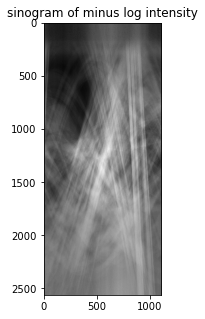

In [47]:
plt.figure(figsize = (5,5))
plt.title('sinogram of minus log intensity')
plt.imshow(proj[:,1,:].T, cmap = 'gray')

 *** Example slice recon done in 0.03 minutes
(5, 2560, 2560)


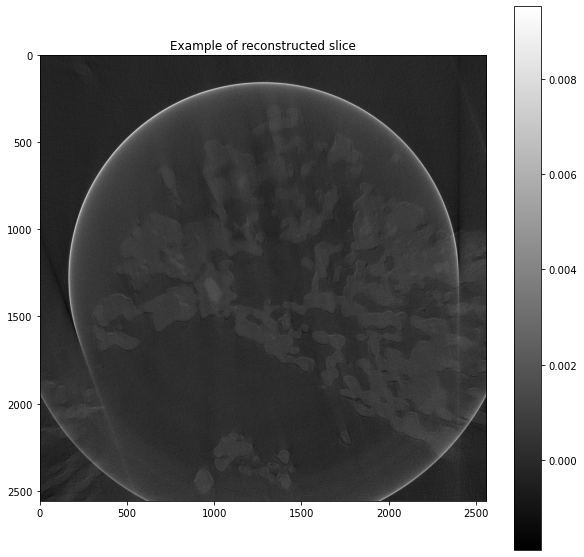

In [52]:
time_start = time.time()

best_center = 1443

recon_slices = tomopy.recon(proj,theta,center=best_center,algorithm='gridrec',filter_name='parzen')
    
time_end  = time.time()
print(' *** Example slice recon done in ' + str(round((time_end-time_start)/60,2)) + ' minutes')

print(recon_slices.shape)
fig, ax = plt.subplots(figsize=(10, 10))
img_plot = plt.imshow(recon_slices[1,:,:], cmap = 'gray')
plt.title('Example of reconstructed slice')
plt.colorbar(orientation='vertical')

## Reconstruct entire dataset

In [55]:
best_recon_center = 1443

chunk_size = 60

time_start = time.time()

for c in range(1600,1660,chunk_size):
#for c in range(0,2160,chunk_size):
    chunk_start = c
    chunk_end = chunk_start+chunk_size
    print('   From: ' + str(chunk_start) + ' to ' + str(chunk_end))
    
    with h5py.File(file_path, 'r') as file:
        tomodata = file["img_tomo"][:,chunk_start:chunk_end,:]

    white = white_prj[:,chunk_start:chunk_end,:]
    dark = dark_prj[:,chunk_start:chunk_end,:]

    #print(' *** Normalizing')
    proj = tomopy.normalize(tomodata, white, dark)
    
    #Phase retrevial
    #proj = tomopy.prep.phase.retrieve_phase(proj)
    
    #print(' *** Remove Stripes')
    proj = tomopy.prep.stripe.remove_all_stripe(proj)
    
    # remove negative numbers
    proj = tomopy.misc.corr.remove_neg(proj, val=1e-3)

    #print(' *** - log')
    proj = tomopy.minus_log(proj)

    # Use full range of projections
    theta = np.linspace(0,2*np.pi*angle_data[-1]/360,angle_data.shape[0])
    
    recon_slices = tomopy.recon(proj,theta,center=best_recon_center,algorithm='gridrec',filter_name='parzen', ncore=4)
    
    for n in range(0,chunk_size):
        im = Image.fromarray(recon_slices[n,:,:])
        im.save("recon_gridrec_parzen_output/slice_" + str(chunk_start+n).zfill(4) + ".tif")

    time_end  = time.time()
    print(' *** Recon time: ' + str(round((time_end-time_start)/60,2)) + ' minutes')


   From: 1600 to 1660
 *** Recon time: 1.37 minutes


## Reconstruction considerations

Reference the [tomopy](https://tomopy.readthedocs.io/en/latest/index.html) documentation to specify the parameters used during recconstruction for best results, example here shows the comparison between regular reconstuction and using default phase retrevial parameters

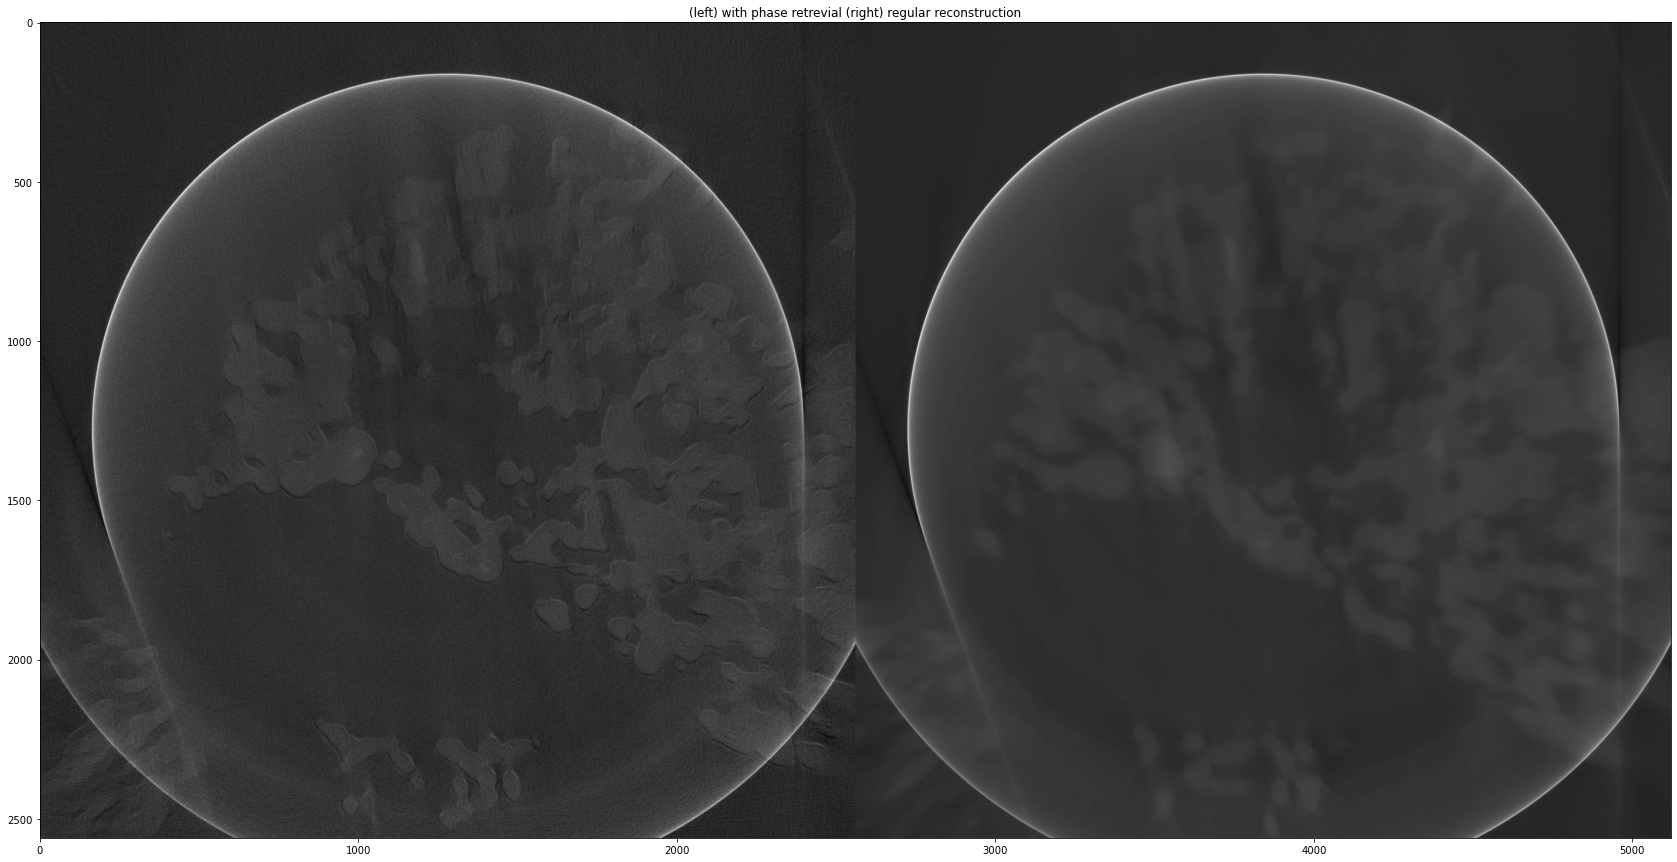

In [56]:
basic_recon = Image.open('recon_gridrec_parzen_output/slice_1600.tif')
phaseret_recon = Image.open('recon_gridrec_parzen_output/slice_1559.tif')

# Montage
recon_slice_images = np.concatenate((basic_recon,phaseret_recon), axis=1)
plt.figure(figsize = (30,15))
plt.title('(left) regular reconstruction (right) with phase retrevial')
plt.imshow(recon_slice_images, cmap = 'gray') #squeeze(), removes axis of size 1


## Summary


For students referencing, please contact Paul Chao (pchao [at] umich.edu) or Kiran (askiran [at] umich.edu) for questions  

API reference for [tomopy](https://tomopy.readthedocs.io/en/latest/index.html)